# Efficient Keyword Spotting for LED Control with TensorFlow Lite for Microcontrollers

This notebook is part of a project to develop an efficient audio keyword spotting system capable of recognizing simple voice commands to control an RGB LED. The model is designed and optimized for deployment on resource-constrained microcontrollers (MCUs) using TensorFlow Lite for Microcontrollers (TFLM).

Full project available on [GitHub](https://github.com/anacletu/tflm-keyword-spotting-led)

## Dataset Exploration

In [1]:
# Importing the relevant libraries
import os
import random
import librosa

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import Audio, display
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Checking TensorFlow and GPU availability
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.16.2
Num GPUs Available:  1


In [3]:
# Global variables

N_MFCC = 13  # Number of MFCCs to return
N_FFT = 512 # Length of the FFT window
HOP_LENGTH = 160 # Number of samples between successive frames
SAMPLE_RATE = 16000 # Sample rate for audio files
BATCH_SIZE = 64 # Batch size for training
TARGET_FRAMES = int(np.ceil(SAMPLE_RATE / HOP_LENGTH)) # Number of frames to target for each audio sample

In [4]:
# Seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED) # For Python's hash-based operations
random.seed(SEED) # For Python's built-in random module
np.random.seed(SEED) # For NumPy operations
tf.random.set_seed(SEED) # For TensorFlow operations


### Helper Functions

In [5]:
def filter_and_label_example(example_audio, example_label_int):
    """
    Processes audio to float32 and normalizes if original was int16.
    Casts label to int32. Uses pure TensorFlow operations.

    Args:
        example_audio: The audio tensor from the dataset.
        example_label_int: The integer label tensor from the dataset (0-11 for v0.0.3).

    Returns:
        A tuple (processed_audio_tensor, model_label_int_tensor)
    """
    audio = tf.cast(example_audio, tf.float32)

    if example_audio.dtype == tf.int16:
        # Normalize int16 data to the range [-1.0, 1.0]
        audio_normalized = audio / 32768.0
    else:
        audio_normalized = audio

    label = tf.cast(example_label_int, tf.int32)
        
    return audio_normalized, label

In [6]:
def map_fn_train(example, label_key):
    """
    Mapping function to be used with tf.data.Dataset.map().
    Extracts audio and label from the example, and passes them to filter_and_label_example.

    Args:
        example: Dictionary with 'audio' and label tensor.
        label_key: Key used to access the label in the dataset (typically 'label').
        config: Configuration dictionary containing class mappings and keywords.

    Returns:
        A tuple (audio_tensor, model_label_int)
    """
    audio = example['audio']
    label = example[label_key]
    return filter_and_label_example(audio, label)


In [7]:
def sample_class_audio(dataset, class_name, config, num_samples=2):
    class_id = config["label_to_int"][class_name]
    
    # Filter dataset for this class
    class_ds = dataset.filter(lambda audio, label: tf.equal(label, class_id))
    
    # Take a few samples
    for i, (audio, label) in enumerate(class_ds.take(num_samples)):
        print(f"Example {i+1} of class '{class_name}':")
        # Play the audio
        display(Audio(audio.numpy(), rate=SAMPLE_RATE))

In [8]:
def extract_mfccs_tf_py_function(audio_tensor, label_tensor):
    """
    Extracts MFCCs from an audio tensor.
    Assumes audio_tensor is already tf.float32 and normalized.
    Assumes label_tensor is tf.int32.

    Args:
        audio_tensor: A tf.float32 tensor of audio data (normalized). Shape (num_samples,).
        label_tensor: A tf.int32 tensor of the label. Shape ().

    Returns:
        A tuple (mfccs_tensor, label_tensor_passthrough).
    """
    def numpy_mfcc_extractor(audio_tensor_arg, label_tensor_arg):
        # Convert input EagerTensors to NumPy arrays FIRST
        audio_np_for_mfcc = audio_tensor_arg.numpy()
        label_np_for_passthrough = label_tensor_arg.numpy()

        # audio_np_for_mfcc is already float32 normalized from the previous step
        mfccs = librosa.feature.mfcc(y=audio_np_for_mfcc,
                                     sr=SAMPLE_RATE,
                                     n_mfcc=N_MFCC,
                                     n_mels=40,
                                     n_fft=N_FFT,
                                     hop_length=HOP_LENGTH,
                                     window='hann')
        
        # Adding padding/truncation to ensure consistent output shape
        if mfccs.shape[1] < TARGET_FRAMES:
            # Pad if too short
            padding_width = TARGET_FRAMES - mfccs.shape[1]
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, padding_width)), mode='constant', constant_values=0)
        elif mfccs.shape[1] > TARGET_FRAMES:
            # Truncate if too long
            mfccs_padded = mfccs[:, :TARGET_FRAMES]
        else:
            # Already correct length
            mfccs_padded = mfccs

        return mfccs_padded.astype(np.float32), label_np_for_passthrough # Ensure MFCCs are float32

    mfcc_output_shape = (N_MFCC, TARGET_FRAMES)  # Shape of the MFCC output tensor

    mfccs_tensor, label_passthrough_tensor = tf.py_function(
        func=numpy_mfcc_extractor,
        inp=[audio_tensor, label_tensor],
        Tout=(tf.float32, tf.int32) # MFCCs are float32
    )

    # Set the shape for the MFCC tensor
    mfccs_tensor.set_shape(mfcc_output_shape)
    # Set the shape for the label tensor (should be scalar)
    if label_tensor.shape == tf.TensorShape([]):
        label_passthrough_tensor.set_shape([])
    else:
        label_passthrough_tensor.set_shape(label_tensor.shape)

    return mfccs_tensor, label_passthrough_tensor

In [9]:
def create_cnn_model(input_shape, num_classes): # Add dropout
    model = keras.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.1), # MILD dropout after pooling

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.15), # MILD dropout

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        # No maxpool
        layers.Dropout(0.2), # MILD dropout after last conv

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3), # Stronger dropout before final dense layers

        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3), # Stronger dropout

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

### Loading and Preparing

In [10]:
# Loading the speech_commands dataset (version 0.0.3) from TensorFlow Datasets
# This version contains 12 classes, including 'unknown' and 'silence'.
# The dataset is split into training, validation, and test sets.

# Defining the path for the dataset
DATA_PATH = os.path.join("..", "data", "raw", "tensorflow_datasets")
os.makedirs(DATA_PATH, exist_ok=True)

try:
    builder = tfds.builder("speech_commands:0.0.3")
    builder.download_and_prepare(download_dir=DATA_PATH)
    ds_train_full, ds_info = tfds.load('speech_commands', split='train', with_info=True, shuffle_files=True, data_dir=DATA_PATH)
    ds_val_full = tfds.load('speech_commands', split='validation', shuffle_files=False, data_dir=DATA_PATH)
    ds_test_full = tfds.load('speech_commands', split='test', shuffle_files=False, data_dir=DATA_PATH)

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e # Stop execution if dataset loading fails

# Displaying the dataset information if successfully loaded
print("\nDataset Information (ds_info):")
print(ds_info)


Dataset Information (ds_info):
tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """

2025-06-13 20:59:55.396172: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-13 20:59:55.396203: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-13 20:59:55.396212: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-13 20:59:55.396228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-13 20:59:55.396241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# Checking the features in the dataset
print("\nFeatures:")
print(ds_info.features)

# Label key for the dataset
label_key = 'label'

# Classes in the dataset
num_total_classes = ds_info.features[label_key].num_classes
print(f"\nTotal number of classes in the dataset: {num_total_classes}")

# String names of the classes
class_names_full = ds_info.features[label_key].names
print(f"\nFull list of class names:")
print(class_names_full)

# Number of examples in each split
print(f"\nNumber of examples in train split: {ds_info.splits['train'].num_examples}")
print(f"Number of examples in validation split: {ds_info.splits['validation'].num_examples}")
print(f"Number of examples in test split: {ds_info.splits['test'].num_examples}")

# Audio sample rate
SAMPLE_RATE = ds_info.features['audio'].sample_rate
print(f"\nSample rate: {SAMPLE_RATE} Hz")


Features:
FeaturesDict({
    'audio': Audio(shape=(None,), dtype=int16),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=12),
})

Total number of classes in the dataset: 12

Full list of class names:
['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']

Number of examples in train split: 85511
Number of examples in validation split: 10102
Number of examples in test split: 4890

Sample rate: 16000 Hz



--- Single Example ---
Audio data shape: (16000,)
Audio data type: int16
Min audio value: -20803, Max audio value: 20202
Integer label: 11
String label: _unknown_


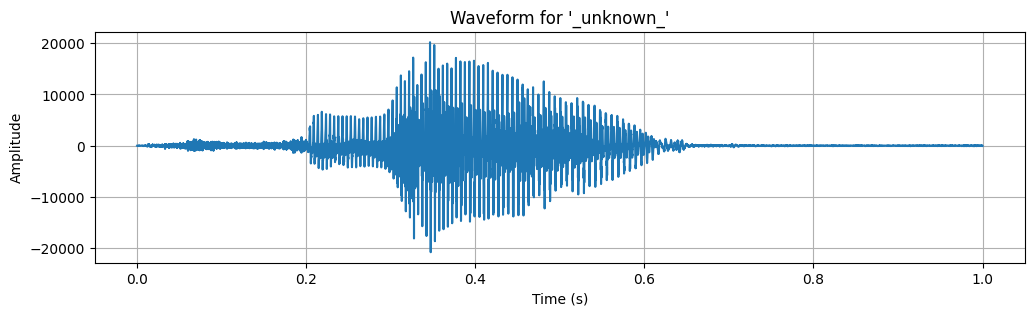


MFCCs shape: (13, 101)


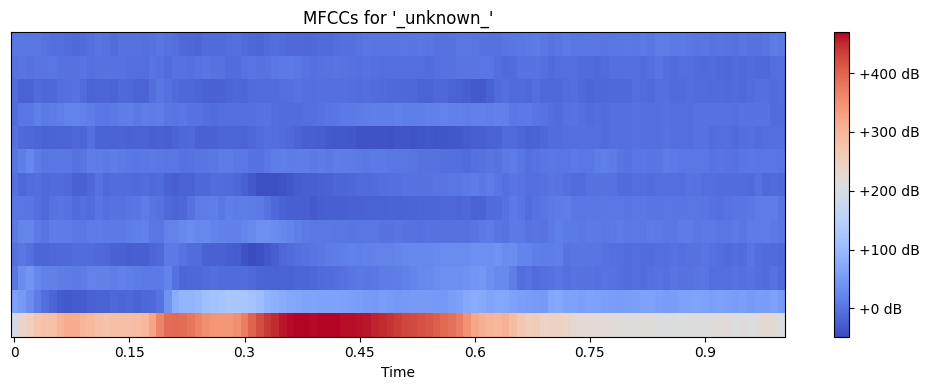

2025-06-13 20:59:56.856817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# Checking one random example from the training dataset for visualization
for example in ds_train_full.take(1):
    audio_data = example['audio'].numpy()
    label_int = example[label_key].numpy()
    label_str = class_names_full[label_int]

    print(f"\n--- Single Example ---")
    print(f"Audio data shape: {audio_data.shape}") 
    print(f"Audio data type: {audio_data.dtype}")
    print(f"Min audio value: {np.min(audio_data)}, Max audio value: {np.max(audio_data)}")
    print(f"Integer label: {label_int}")
    print(f"String label: {label_str}")

    # Visualizing the waveform
    plt.figure(figsize=(12, 3))
    plt.plot(np.linspace(0, len(audio_data) / SAMPLE_RATE, num=len(audio_data)), audio_data)
    plt.title(f"Waveform for '{label_str}'")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Audio playback for testing
    display(Audio(audio_data, rate=SAMPLE_RATE, autoplay=True))
    
    # Ensure audio_data is float for librosa
    mfccs = librosa.feature.mfcc(y=audio_data.astype(float),
                                 sr=SAMPLE_RATE,
                                 n_mfcc=N_MFCC,
                                 n_mels=40,
                                 n_fft=N_FFT,
                                 hop_length=HOP_LENGTH)

    print(f"\nMFCCs shape: {mfccs.shape}") # (n_mfcc, n_frames)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time')
    plt.colorbar(format='%+2.0f dB') # Colorbar shows decibels
    plt.title(f"MFCCs for '{label_str}'")
    plt.tight_layout()
    plt.show()

# Cleaning up
del example, audio_data, label_int, label_str, mfccs

In [13]:
# 1. Define the labels the MODEL will learn and predict.
config = {}
num_classes = ds_info.features[label_key].num_classes
config["all_model_labels"] = class_names_full
print(f"All labels the model will learn (all_model_labels): {config['all_model_labels']}")
print(f"Number of classes model will predict: {num_classes}") 

# 2. Create mappings for these model labels
config["label_to_int"] = {label: i for i, label in enumerate(config["all_model_labels"])}
config["int_to_label"] = {i: label for i, label in enumerate(config["all_model_labels"])} 
print(f"\nLabel to int mapping for model: {config['label_to_int']}")
print(f"Int to label mapping for model: {config['int_to_label']}")

# 3. Define the application-specific target keywords for LED control (just for reference).
config["target_keywords"] = ["up", "down", "left", "on", "off"] # 
print(f"\nApplication target keywords for LED control: {config['target_keywords']}")

All labels the model will learn (all_model_labels): ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']
Number of classes model will predict: 12

Label to int mapping for model: {'down': 0, 'go': 1, 'left': 2, 'no': 3, 'off': 4, 'on': 5, 'right': 6, 'stop': 7, 'up': 8, 'yes': 9, '_silence_': 10, '_unknown_': 11}
Int to label mapping for model: {0: 'down', 1: 'go', 2: 'left', 3: 'no', 4: 'off', 5: 'on', 6: 'right', 7: 'stop', 8: 'up', 9: 'yes', 10: '_silence_', 11: '_unknown_'}

Application target keywords for LED control: ['up', 'down', 'left', 'on', 'off']


### Testing the Helper Functions

In [14]:
# Test Case 1: A word that is one of the 10 core commands
test_word_core_command = "on"
n_iterations = 2000 # Iterate enough to find it

print(f"\n--- Testing with a core command: '{test_word_core_command}' ---")
found_core_command = False
for ex in ds_train_full.take(n_iterations): 
    # Get the original string label from the dataset
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_word_core_command:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )

        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}")
        print(f"Processed model label int: {processed_label_int}")
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_core_command = True
        
        # Audio playback for testing
        display(Audio(processed_audio_tensor.numpy(), rate=SAMPLE_RATE, autoplay=True))
        break

if not found_core_command:
    print(f"Could not find an example of '{test_word_core_command}' in the first {n_iterations} samples of ds_train_full.")

# Cleaning up
del ex, original_dataset_label_str, processed_audio_tensor, processed_label_int_tensor, processed_label_int



--- Testing with a core command: 'on' ---
Original dataset label string: 'on'
Original dataset label int: 5
Processed model label int: 5
Processed model label string (from config['int_to_label']): on


In [15]:
# Test Case 2: An example that TFDS v0.0.3 labels as '_unknown_'
test_dataset_label_is_unknown = "_unknown_" 

print(f"\n--- Testing with an example labeled as '{test_dataset_label_is_unknown}' by the dataset ---")
found_unknown_example = False
for ex in ds_train_full.take(n_iterations): 
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_dataset_label_is_unknown:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )
        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}") # Should be index of '_unknown_'
        print(f"Processed model label int: {processed_label_int}")   # Should be the same index
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_unknown_example = True

        # Audio playback for testing
        display(Audio(processed_audio_tensor.numpy(), rate=SAMPLE_RATE, autoplay=True))
        break
if not found_unknown_example:
    print(f"Could not find an example labeled as '{test_dataset_label_is_unknown}' in the first {n_iterations} samples of ds_train_full.")

# Cleaning up
del ex, original_dataset_label_str, processed_audio_tensor, processed_label_int_tensor, processed_label_int


--- Testing with an example labeled as '_unknown_' by the dataset ---
Original dataset label string: '_unknown_'
Original dataset label int: 11
Processed model label int: 11
Processed model label string (from config['int_to_label']): _unknown_


In [16]:
# Test Case 3: An example labeled as '_silence_' by the dataset
test_dataset_label_is_silence = "_silence_"

print(f"\n--- Testing with an example labeled as '{test_dataset_label_is_silence}' by the dataset ---")
found_silence_example = False
for ex in ds_train_full.take(n_iterations): 
    original_dataset_label_str = class_names_full[ex[label_key].numpy()]

    if original_dataset_label_str == test_dataset_label_is_silence:
        processed_audio_tensor, processed_label_int_tensor = filter_and_label_example(
            ex['audio'], ex[label_key]
        )
        processed_label_int = processed_label_int_tensor.numpy()

        print(f"Original dataset label string: '{original_dataset_label_str}'")
        print(f"Original dataset label int: {ex[label_key].numpy()}")
        print(f"Processed model label int: {processed_label_int}")
        print(f"Processed model label string (from config['int_to_label']): {config['int_to_label'][processed_label_int]}")
        found_silence_example = True

        # Audio playback for testing
        display(Audio(processed_audio_tensor.numpy(), rate=SAMPLE_RATE, autoplay=True))
        break
if not found_silence_example:
    print(f"Could not find an example labeled as '{test_dataset_label_is_silence}' in the first {n_iterations} samples of ds_train_full.")

# Cleaning up
del ex, original_dataset_label_str, processed_audio_tensor, processed_label_int_tensor, processed_label_int


--- Testing with an example labeled as '_silence_' by the dataset ---
Original dataset label string: '_silence_'
Original dataset label int: 10
Processed model label int: 10
Processed model label string (from config['int_to_label']): _silence_


In [17]:
# Wrap the map function with predefined arguments
map_fn = partial(map_fn_train, label_key=label_key)

# Apply the mapping
ds_train_mapped = ds_train_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_mapped = ds_val_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_mapped = ds_test_full.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)

## Class Imbalance

2025-06-13 21:00:04.278584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


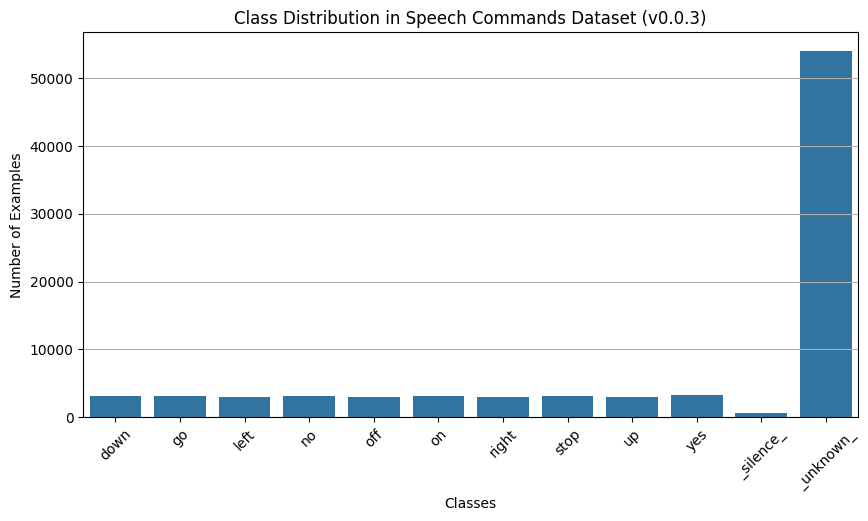

In [18]:
class_counts = np.zeros(num_classes, dtype=int)
for _, label in ds_train_mapped:
    class_counts[label.numpy()] += 1

plt.figure(figsize=(10, 5))
sns.barplot(x=config["all_model_labels"], y=class_counts)
plt.title("Class Distribution in Speech Commands Dataset (v0.0.3)")
plt.xlabel("Classes")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [19]:
# Create separate datasets for each class
ds_unknown = ds_train_mapped.filter(
    lambda audio, label: tf.equal(label, config["label_to_int"]["_unknown_"])
)
ds_silence = ds_train_mapped.filter(
    lambda audio, label: tf.equal(label, config["label_to_int"]["_silence_"])
)
ds_others = ds_train_mapped.filter(
    lambda audio, label: tf.logical_and(
        tf.not_equal(label, config["label_to_int"]["_unknown_"]),
        tf.not_equal(label, config["label_to_int"]["_silence_"])
    )
)

# Undersample _unknown_ class
ds_unknown_sampled = ds_unknown.take(10000)

# Oversample _silence_ class
ds_silence_oversampled = ds_silence.repeat(2)

# Calculate balanced dataset size
ds_size = 0
for _ in ds_others.concatenate(ds_unknown_sampled).concatenate(ds_silence_oversampled):
    ds_size += 1

# Combine datasets and shuffle
ds_train_mapped_balanced = ds_others.concatenate(ds_unknown_sampled).concatenate(ds_silence_oversampled)
ds_train_mapped_balanced = ds_train_mapped_balanced.shuffle(ds_size, seed=SEED)

2025-06-13 21:00:19.731185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-06-13 21:00:29.812572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41392 of 42105
2025-06-13 21:00:34.364150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-06-13 21:00:37.397837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


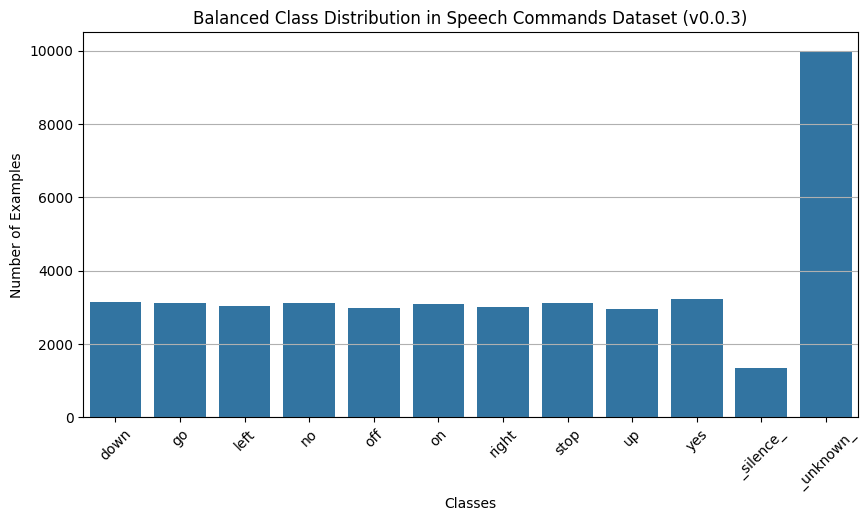

In [20]:
# Class distribution after balancing
class_counts_balanced = np.zeros(num_classes, dtype=int)
for _, label in ds_train_mapped_balanced:
    class_counts_balanced[label.numpy()] += 1
plt.figure(figsize=(10, 5))
sns.barplot(x=config["all_model_labels"], y=class_counts_balanced)
plt.title("Balanced Class Distribution in Speech Commands Dataset (v0.0.3)")
plt.xlabel("Classes")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [21]:
# Sample and play examples from the balanced dataset
print("\n--- Sampling Audio Examples from Balanced Dataset ---")

# Sample examples of regular commands
for keyword in ["up", "down", "on", "off"]:
    if keyword in config["all_model_labels"]:
        sample_class_audio(ds_train_mapped_balanced, keyword, config)

# Sample examples of special classes
sample_class_audio(ds_train_mapped_balanced, "_unknown_", config)
sample_class_audio(ds_train_mapped_balanced, "_silence_", config)


--- Sampling Audio Examples from Balanced Dataset ---


2025-06-13 21:00:47.529293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41310 of 42105


Example 1 of class 'up':


2025-06-13 21:00:52.372562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Example 2 of class 'up':


2025-06-13 21:00:52.710015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-13 21:01:02.775610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41438 of 42105


Example 1 of class 'down':


2025-06-13 21:01:07.123974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Example 2 of class 'down':


2025-06-13 21:01:07.456802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-13 21:01:17.500078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41312 of 42105


Example 1 of class 'on':


2025-06-13 21:01:22.329644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Example 2 of class 'on':


2025-06-13 21:01:22.648833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-13 21:01:32.681913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41465 of 42105


Example 1 of class 'off':


2025-06-13 21:01:36.422427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Example 2 of class 'off':


2025-06-13 21:01:36.862052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-13 21:01:46.898961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41176 of 42105


Example 1 of class '_unknown_':


2025-06-13 21:01:53.164515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Example 2 of class '_unknown_':


2025-06-13 21:01:53.493577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-13 21:02:03.524573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41185 of 42105


Example 1 of class '_silence_':


2025-06-13 21:02:09.376239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Example 2 of class '_silence_':


2025-06-13 21:02:09.709760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Feature Extraction (MFCCs) and Final Dataset Preparation

### MFCC Feature Extraction


--- Testing MFCC Extraction ---
Original audio shape: (16000,), Original label: 8
MFCC features shape: (13, 100)
Label after MFCC: 8


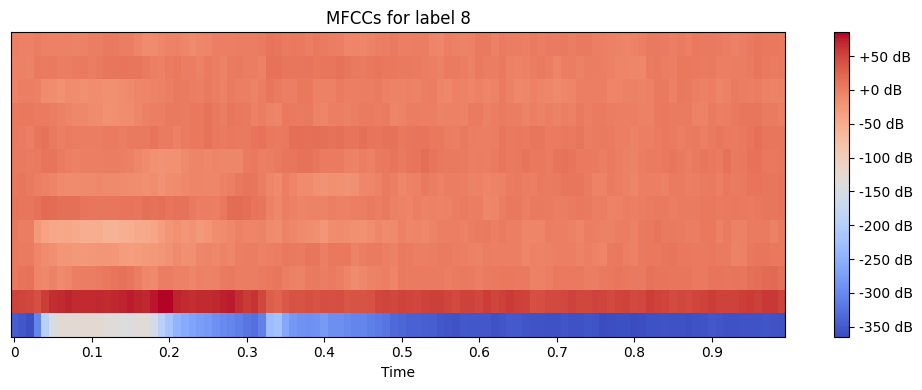

In [22]:
# Testing the MFCC extraction function
print("\n--- Testing MFCC Extraction ---")
for audio_sample, label_sample in ds_train_mapped.take(1):
    print(f"Original audio shape: {audio_sample.shape}, Original label: {label_sample.numpy()}")
    mfcc_features, label_after_mfcc = extract_mfccs_tf_py_function(audio_sample, label_sample)
    print(f"MFCC features shape: {mfcc_features.shape}") # Should be (N_MFCC, num_frames_calculated)
    print(f"Label after MFCC: {label_after_mfcc.numpy()}")
    
    # Plot the MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc_features.numpy(), # Convert to numpy for plotting
                             sr=SAMPLE_RATE,
                             hop_length=HOP_LENGTH,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"MFCCs for label {label_after_mfcc.numpy()}")
    plt.tight_layout()
    plt.show()

    # Audio playback for testing
    display(Audio(audio_sample.numpy(), rate=SAMPLE_RATE, autoplay=True))
    break

# Cleaning up
del audio_sample, label_sample, mfcc_features, label_after_mfcc

In [23]:
# Applying the MFCC extraction function to the datasets
ds_train_features = ds_train_mapped_balanced.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_features = ds_val_mapped.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_features = ds_test_mapped.map(extract_mfccs_tf_py_function, num_parallel_calls=tf.data.AUTOTUNE)

# Check the first element of the new dataset
print("\n--- First example from dataset with MFCC features ---")
for mfcc_ex, label_ex in ds_train_features.take(1):
    print(f"MFCC example shape: {mfcc_ex.shape}, Label: {label_ex.numpy()}")


--- First example from dataset with MFCC features ---


2025-06-13 21:02:20.231908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41439 of 42105
2025-06-13 21:02:24.345438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


MFCC example shape: (13, 100), Label: 5


2025-06-13 21:02:24.788716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Preparing Individual Samples for Serial Testing

In [24]:
# Adding a channel dimension for CNN input
ds_test_individual_samples_with_channel = ds_test_features.map(
    lambda mfcc_sample, label_sample: (tf.expand_dims(mfcc_sample, axis=-1), label_sample),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Cache the dataset to speed up subsequent operations
test_sender_cache_file = os.path.join('.tf_cache/', "test_individual_for_sender_cache")
ds_test_for_sender_source = ds_test_individual_samples_with_channel.cache(filename=test_sender_cache_file)

print("`ds_test_for_sender_source` is ready. It yields individual processed MFCCs with channel.")


# --- Save some samples from ds_test_for_sender_source for the Python sender script ---
samples_to_save = {
    "on": None,
    "off": None,
    "up": None, # Example for red
    "down": None, # Example for blue
    "right": None, # Example for green
    "left": None,
    "_silence_": None,
    "_unknown_": None
}
num_to_find_each = 1 # Save one of each

# Make sure the 'test_samples_for_arduino' directory exists
SAMPLES_DIR = '../utils/test_samples_for_arduino'
os.makedirs(SAMPLES_DIR, exist_ok=True)

# Iterate through the dataset to find and save one instance of each desired label
# Shuffle to get different samples if run multiple times
temp_ds_for_saving = ds_test_for_sender_source.shuffle(1000, seed=None) 

found_counts = {key: 0 for key in samples_to_save}

print(f"Searching for and saving specific samples to '{SAMPLES_DIR}/'...")
for mfcc_HWC_tensor, label_tensor in temp_ds_for_saving.take(2000): # Search within first 2000 samples
    label_int = label_tensor.numpy()
    label_str = config['int_to_label'].get(label_int, "ERROR_UNKNOWN_LABEL_INT")

    if label_str in samples_to_save and found_counts[label_str] < num_to_find_each:
        sample_np = mfcc_HWC_tensor.numpy()
        filename = os.path.join(SAMPLES_DIR, f"sample_mfcc_{label_str}.npy")
        np.save(filename, sample_np)
        print(f"Saved: {filename} (shape: {sample_np.shape}, label: {label_str})")
        samples_to_save[label_str] = "saved" # Mark as found and saved
        found_counts[label_str] += 1
        # Check if all desired samples are found
        if all(count >= num_to_find_each for count in found_counts.values()):
            break
print("Sample saving complete.")

`ds_test_for_sender_source` is ready. It yields individual processed MFCCs with channel.
Searching for and saving specific samples to '../utils/test_samples_for_arduino/'...
Saved: ../utils/test_samples_for_arduino/sample_mfcc_down.npy (shape: (13, 100, 1), label: down)
Saved: ../utils/test_samples_for_arduino/sample_mfcc_left.npy (shape: (13, 100, 1), label: left)
Saved: ../utils/test_samples_for_arduino/sample_mfcc__silence_.npy (shape: (13, 100, 1), label: _silence_)
Saved: ../utils/test_samples_for_arduino/sample_mfcc__unknown_.npy (shape: (13, 100, 1), label: _unknown_)
Saved: ../utils/test_samples_for_arduino/sample_mfcc_off.npy (shape: (13, 100, 1), label: off)
Saved: ../utils/test_samples_for_arduino/sample_mfcc_up.npy (shape: (13, 100, 1), label: up)
Saved: ../utils/test_samples_for_arduino/sample_mfcc_right.npy (shape: (13, 100, 1), label: right)
Saved: ../utils/test_samples_for_arduino/sample_mfcc_on.npy (shape: (13, 100, 1), label: on)
Sample saving complete.


2025-06-13 21:02:29.547666: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Cache, Shuffle, and Batch the Datasets


In [25]:
# Caching the TRAINING dataset for performance
CACHE_DIR = os.path.join(os.getcwd(), ".tf_cache") # In current notebook dir, hidden folder
os.makedirs(CACHE_DIR, exist_ok=True) # Create directory if it doesn't exist

train_cache_file = os.path.join(CACHE_DIR, "train_mfcc_cache")
val_cache_file = os.path.join(CACHE_DIR, "val_mfcc_cache")
test_cache_file = os.path.join(CACHE_DIR, "test_mfcc_cache")

print("Preparing ds_train...")
ds_train_intermediate = ds_train_features.cache(filename=train_cache_file) # Cache the training dataset
print(f"Cached ds_train to {train_cache_file}")

# Calculate the number of elements in the training dataset for the shuffle buffer
print("Calculating shuffle buffer size for ds_train...")
SHUFFLE_BUFFER_SIZE = 0
for _ in ds_train_intermediate:
    SHUFFLE_BUFFER_SIZE += 1
print(f"Calculated SHUFFLE_BUFFER_SIZE for ds_train: {SHUFFLE_BUFFER_SIZE}")

# Now apply shuffle, batch, prefetch
ds_train = ds_train_intermediate.shuffle(SHUFFLE_BUFFER_SIZE, seed=SEED, reshuffle_each_iteration=True)
ds_train = ds_train.repeat()
ds_train = ds_train.map(
    lambda mfcc_sample, label_sample: (tf.expand_dims(mfcc_sample, axis=-1), label_sample),
    num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
print("ds_train preparation complete.")


Preparing ds_train...
Cached ds_train to /Users/anacleto/Documents/Estudos/M.S. Computer Science/2025/Artificial Intelligence/tflm-keyword-spotting-led/notebooks/.tf_cache/train_mfcc_cache
Calculating shuffle buffer size for ds_train...


2025-06-13 21:02:39.631367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:1529: Filling up shuffle buffer (this may take a while): 41301 of 42105
2025-06-13 21:02:45.529677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Calculated SHUFFLE_BUFFER_SIZE for ds_train: 42105
ds_train preparation complete.


2025-06-13 21:05:29.701812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-13 21:05:29.702446: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [26]:
# Prepare the VALIDATION dataset
print("\nPreparing ds_val...")
ds_val = ds_val_features.cache(filename=val_cache_file) # Cache the validation dataset
print(f"Cached ds_val to {val_cache_file}")
ds_val = ds_val.map(
    lambda mfcc_sample, label_sample: (tf.expand_dims(mfcc_sample, axis=-1), label_sample),
    num_parallel_calls=tf.data.AUTOTUNE
)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)
print("ds_val preparation complete.")


Preparing ds_val...
Cached ds_val to /Users/anacleto/Documents/Estudos/M.S. Computer Science/2025/Artificial Intelligence/tflm-keyword-spotting-led/notebooks/.tf_cache/val_mfcc_cache
ds_val preparation complete.


In [27]:
# Prepare the TEST dataset
print("\nPreparing ds_test...")
ds_test = ds_test_features.cache(filename=test_cache_file) # Cache the test dataset
print(f"Cached ds_test to {test_cache_file}")
ds_test = ds_test.map(
    lambda mfcc_sample, label_sample: (tf.expand_dims(mfcc_sample, axis=-1), label_sample),
    num_parallel_calls=tf.data.AUTOTUNE
)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
print("ds_test preparation complete.")


Preparing ds_test...
Cached ds_test to /Users/anacleto/Documents/Estudos/M.S. Computer Science/2025/Artificial Intelligence/tflm-keyword-spotting-led/notebooks/.tf_cache/test_mfcc_cache
ds_test preparation complete.


In [28]:
# Verify the output of one batch from the prepared training data
print("\n--- Shape of one batch from final processed training data (ds_train) ---")
for mfcc_batch, label_batch in ds_train.take(1):
    print(f"MFCC batch shape: {mfcc_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Data type of MFCC batch: {mfcc_batch.dtype}")
    print(f"Data type of Label batch: {label_batch.dtype}")
    break

print("\n--- Shape of one batch from final processed validation data (ds_val) ---")
for mfcc_batch_val, label_batch_val in ds_val.take(1):
    print(f"MFCC batch shape (validation): {mfcc_batch_val.shape}")
    print(f"Label batch shape (validation): {label_batch_val.shape}")
    break

print("\n--- Shape of one batch from final processed test data (ds_test) ---")
for mfcc_batch_test, label_batch_test in ds_test.take(1):
    print(f"MFCC batch shape (test): {mfcc_batch_test.shape}")
    print(f"Label batch shape (test): {label_batch_test.shape}")
    break

print("\nDataset preparation complete for training, validation, and testing!")


--- Shape of one batch from final processed training data (ds_train) ---
MFCC batch shape: (64, 13, 100, 1)
Label batch shape: (64,)
Data type of MFCC batch: <dtype: 'float32'>
Data type of Label batch: <dtype: 'int32'>

--- Shape of one batch from final processed validation data (ds_val) ---
MFCC batch shape (validation): (64, 13, 100, 1)
Label batch shape (validation): (64,)

--- Shape of one batch from final processed test data (ds_test) ---


2025-06-13 21:05:30.416156: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


MFCC batch shape (test): (64, 13, 100, 1)
Label batch shape (test): (64,)

Dataset preparation complete for training, validation, and testing!


2025-06-13 21:05:30.809257: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [29]:
# Determine input shape for the model
input_shape_for_model = (N_MFCC, TARGET_FRAMES, 1) # (height, width, channels)
print(f"Input shape for the model: {input_shape_for_model}")

# Number of output classes
print(f"Number of output classes: {num_classes}")

Input shape for the model: (13, 100, 1)
Number of output classes: 12


## Defining the CNN Model

In [30]:
# Create the model instance
model = create_cnn_model(input_shape_for_model, num_classes)

# Print the model summary
model.summary()

/Users/anacleto/Documents/Estudos/M.S. Computer Science/2025/Artificial Intelligence/tflm-keyword-spotting-led/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 100, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 50, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 50, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 50, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 25, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 25, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,772 (100.67 KB)

 Trainable params: 25,772 (100.67 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), # LR accuracy
    loss='sparse_categorical_crossentropy', # For multi-class classification with integer labels
    metrics=['accuracy'] # Track accuracy during training
)
print("Model compiled successfully.")

Model compiled successfully.


### Training the Model

In [32]:
# ModelCheckpoint: Save the model or weights at some frequency.
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras', # Keras v3 native format
    save_weights_only=False,    # Save the full model
    monitor='val_accuracy',     # Monitor validation accuracy
    mode='max',                 # Mode for val_accuracy should be 'max'
    save_best_only=True         # Only save if 'val_accuracy' has improved
)

# EarlyStopping: Stop training when a monitored metric has stopped improving.
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=10,                # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min',                 # Mode for val_loss should be 'min'
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity.
)

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5, # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=0.00001, # Lower bound on the learning rate.
    verbose=1,
    mode='min'
)

callbacks_list = [
    model_checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback
]

In [33]:
# Fitting the model (no class weights)
EPOCHS = 100 # EarlyStopping might stop it sooner.

print("\n--- Starting Model Training ---")
history = model.fit(
    ds_train,                   # Prepared training dataset
    epochs=EPOCHS,
    validation_data=ds_val,     # Prepared validation dataset
    callbacks=callbacks_list,    # Pass the list of callbacks
    steps_per_epoch= SHUFFLE_BUFFER_SIZE // BATCH_SIZE,
)
print("--- Model Training Finished ---")


--- Starting Model Training ---
Epoch 1/100


2025-06-13 21:05:31.482549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


657/657 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.1024 - loss: 7.3226 - val_accuracy: 0.5958 - val_loss: 2.1424 - learning_rate: 1.0000e-04
Epoch 2/100
  1/657 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.0625 - loss: 2.9512

2025-06-13 21:06:37.179948: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1448 - loss: 2.7471 - val_accuracy: 0.6034 - val_loss: 2.0339 - learning_rate: 1.0000e-04
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.2003 - loss: 2.4503 - val_accuracy: 0.5126 - val_loss: 1.9530 - learning_rate: 1.0000e-04
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.2116 - loss: 2.3551 - val_accuracy: 0.5325 - val_loss: 1.7516 - learning_rate: 1.0000e-04
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.2279 - loss: 2.2800 - val_accuracy: 0.5546 - val_loss: 1.6095 - learning_rate: 1.0000e-04
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.2553 - loss: 2.1986 - val_accuracy: 0.5680 - val_loss: 1.5207 - learning_rate: 1.0000e-04
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.2753 - loss: 2.1262 - val_accuracy: 0.5715 - val_loss: 1.4943 - learning_rate: 1.0000e-04
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - a


--- Plotting Training History ---


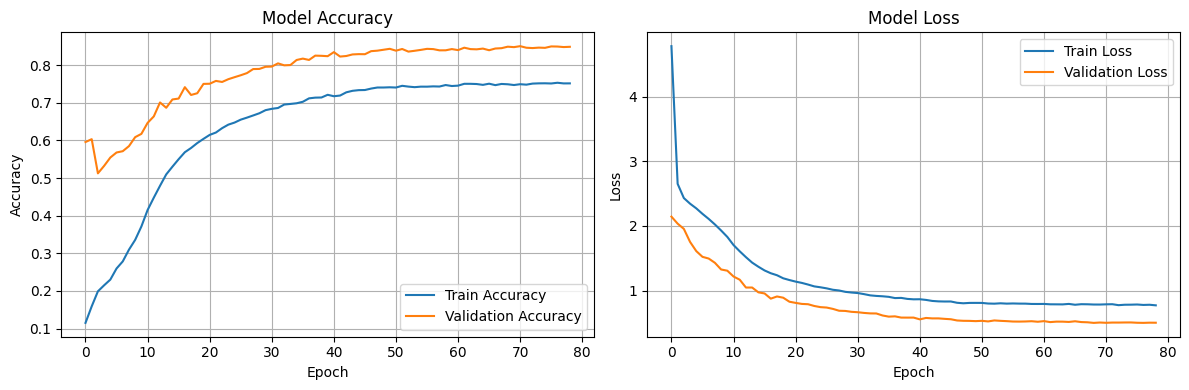

In [34]:
print("\n--- Plotting Training History ---")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluating the Model on Unseen Data

In [35]:
# Model Evaluation
print("\n--- Evaluating Model on Test Set ---")

try:
    print("\nLoading 'best_model.keras' saved by ModelCheckpoint (based on val_accuracy)...")
    best_model_on_val_acc = keras.models.load_model('best_model.keras')
    print("Model loaded successfully.")

    test_loss_best_val_acc, test_accuracy_best_val_acc = best_model_on_val_acc.evaluate(ds_test, verbose=1)
    print(f"\nTest Loss (from best_model.keras based on val_accuracy): {test_loss_best_val_acc:.4f}")
    print(f"Test Accuracy (from best_model.keras based on val_accuracy): {test_accuracy_best_val_acc:.4f}")
except Exception as e:
    print(f"Could not load or evaluate 'best_model.keras': {e}")
    print("Continuing with the model from EarlyStopping.")


--- Evaluating Model on Test Set ---

Loading 'best_model.keras' saved by ModelCheckpoint (based on val_accuracy)...
Model loaded successfully.
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 298ms/step - accuracy: 0.8437 - loss: 0.5040

Test Loss (from best_model.keras based on val_accuracy): 0.5071
Test Accuracy (from best_model.keras based on val_accuracy): 0.8446


2025-06-13 21:23:01.283715: W tensorflow/core/kernels/data/cache_dataset_ops.cc:302] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.



--- Generating Predictions and Confusion Matrix ---
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape of y_pred_classes: (4890,)
Shape of y_true: (4890,)

Classification Report:
              precision    recall  f1-score   support

        down       0.86      0.77      0.82       406
          go       0.83      0.63      0.71       402
        left       0.88      0.86      0.87       412
          no       0.76      0.77      0.76       405
         off       0.91      0.81      0.86       402
          on       0.93      0.84      0.88       396
       right       0.98      0.84      0.90       396
        stop       0.96      0.89      0.93       411
          up       0.84      0.89      0.87       425
         yes       0.92      0.96      0.94       419
   _silence_       0.96      0.99      0.97       408
   _unknown_       0.53      0.87      0.66       408

    accuracy                           0.84      4890
   macro avg       0.86      0.84      0.85      4890
weighted avg  

2025-06-13 21:23:01.729291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


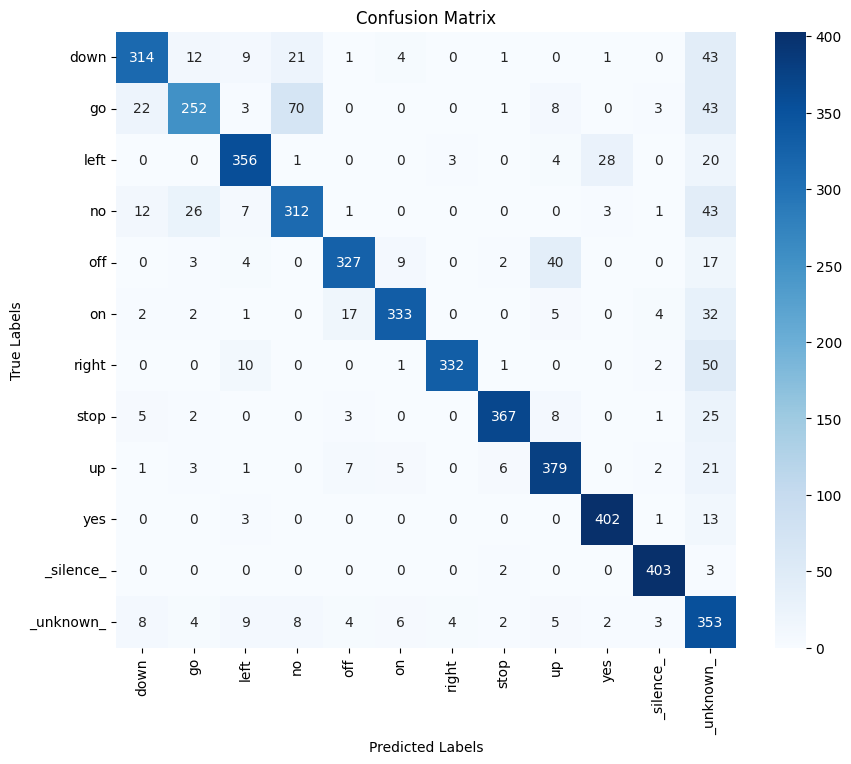

In [36]:
# Predictions 
print("\n--- Generating Predictions and Confusion Matrix ---")
y_pred_probs = best_model_on_val_acc.predict(ds_test) # Get probability scores for each class
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Get the class with the highest probability

# Get true labels from the test set
y_true = []
for _, labels_batch in ds_test: # ds_test yields (mfcc_batch, label_batch)
    y_true.extend(labels_batch.numpy())
y_true = np.array(y_true)

# Ensure shapes match (number of predictions should equal number of true labels)
print(f"Shape of y_pred_classes: {y_pred_classes.shape}")
print(f"Shape of y_true: {y_true.shape}")

if len(y_pred_classes) != len(y_true):
    print("Warning: Mismatch in number of predictions and true labels. Confusion matrix might be incorrect.")
    # This can happen if ds_test was not fully iterated or if batching caused issues with the last batch.
    min_len = min(len(y_pred_classes), len(y_true))
    y_pred_classes = y_pred_classes[:min_len]
    y_true = y_true[:min_len]
    print(f"Adjusted shapes to: y_pred_classes: {y_pred_classes.shape}, y_true: {y_true.shape}")

    # Classification Report (Precision, Recall, F1-score)
if 'config' in locals() and 'all_model_labels' in config:
    report_target_names = config["all_model_labels"]
    # Ensure labels in y_true and y_pred_classes are within the range of report_target_names indices
    max_label_val = max(np.max(y_true), np.max(y_pred_classes))
    if max_label_val >= len(report_target_names):
        print(f"Warning: Max label value ({max_label_val}) exceeds number of target names ({len(report_target_names)}). Report might be misaligned.")
        # Create generic target names if misalignment is suspected
        report_target_names = [f"Class {i}" for i in range(max_label_val + 1)]


    print("\nClassification Report:")
    # Ensure y_true and y_pred_classes contain integer labels [0, num_classes-1]
    # Also, ensure all labels present in y_true and y_pred_classes are covered by target_names
    # If some classes are not predicted or not present in y_true for the test set, they might be missing from the report.
    # Use zero_division=0 to handle cases where a class has no true samples or no predicted samples.
    try:
        print(classification_report(y_true, y_pred_classes, target_names=report_target_names, zero_division=0))
    except ValueError as ve:
        print(f"ValueError in classification_report: {ve}")
        print("This might happen if labels in y_true/y_pred_classes are outside the expected range [0, num_classes-1] or if target_names length mismatch.")
        print("Printing report without target_names for debugging:")
        print(classification_report(y_true, y_pred_classes, zero_division=0))


# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=report_target_names if 'report_target_names' in locals() else "auto",
            yticklabels=report_target_names if 'report_target_names' in locals() else "auto")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Saving the model if testing accuracy is satisfactory
accuracy_threshold = 0.85 # Define a threshold for saving the model
if test_accuracy_best_val_acc >= accuracy_threshold:
    models_dir = os.path.join('..', 'models')
    os.makedirs(models_dir, exist_ok=True) # Ensure the models directory exists

    final_model_name = f'final_model_test_acc_{test_accuracy_best_val_acc:.2f}.keras'
    final_model_path = os.path.join('../models', final_model_name)

    print(f"\n--- Saving the trained model as {final_model_name} to {models_dir} ---")
    best_model_on_val_acc.save(final_model_path)
    print("Model saved successfully.")

    # Removing the best_model.keras file from the current directory as it is no longer needed
    if os.path.exists('best_model.keras'):
        os.remove('best_model.keras')
        print("Removed 'best_model.keras' as it has been saved in the models directory with a more descriptive name.")
else:
    print(f"\n--- Model accuracy ({test_accuracy_best_val_acc:.2f}) is below threshold ({accuracy_threshold}). Not saving the model. ---")


--- Model accuracy (0.84) is below threshold (0.85). Not saving the model. ---


## TFLM Conversion & Quantization

In [59]:
# Loading the best model with priority to saved high-accuracy models
models_dir = os.path.join('..', 'models')
model_files = [f for f in os.listdir(models_dir) if f.startswith('final_model_test_acc_') and f.endswith('.keras')] if os.path.exists(models_dir) else []

if model_files:
    # Sort by accuracy (descending) if multiple files exist
    model_files.sort(reverse=True)
    best_model_path = os.path.join(models_dir, model_files[0])
    print(f"\nLoading saved high-accuracy model: {model_files[0]}")
    loaded_keras_model = tf.keras.models.load_model(best_model_path)
    print(f"Model loaded successfully from {best_model_path}")
    
elif 'best_model_on_val_acc' in locals() and best_model_on_val_acc is not None:
    print("\nWARNING: No saved high-accuracy model found in models directory.")
    print(f"Using model from memory, which may not have reached the accuracy threshold ({accuracy_threshold}).")
    loaded_keras_model = best_model_on_val_acc
    
else:
    try:
        print("\nWARNING: No saved high-accuracy model found in models directory.")
        print("No model in memory. Attempting to load 'best_model.keras' from current directory...")
        loaded_keras_model = tf.keras.models.load_model('best_model.keras')
        print("Model loaded from current directory, but may not have reached accuracy threshold.")
    except Exception as e:
        print(f"Error loading model: {e}")
        raise e


Loading saved high-accuracy model: final_model_test_acc_0.86.keras
Model loaded successfully from ../models/final_model_test_acc_0.86.keras


In [124]:
# Ensure 'loaded_keras_model' contains your best Keras model object from the previous cell
if 'loaded_keras_model' not in locals() or loaded_keras_model is None:
    raise RuntimeError("Keras model ('loaded_keras_model') not found or is None. Please load a Keras model first.")

# Prepare the directory for saving TFLite models
tflite_models_dir_relative = os.path.join('..', 'tflite_models')
os.makedirs(tflite_models_dir_relative, exist_ok=True)
print(f"TFLite models will be saved in: {os.path.abspath(tflite_models_dir_relative)}")

# Convert the Keras model to TFLite format
print("\n--- Converting Keras model to TFLite format (Float32) ---")
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_keras_model)
tflite_model_float32 = converter.convert()

# Save the Float32 TFLite model
float32_model_path = os.path.join(tflite_models_dir_relative, f'keyword_spotting_model_{test_accuracy_best_val_acc:.2f}_float32.tflite')
with open(float32_model_path, 'wb') as f:
    f.write(tflite_model_float32)
print(f"Float32 TFLite model saved to {float32_model_path}, Size: {os.path.getsize(float32_model_path)/1024:.2f} KB")

TFLite models will be saved in: /Users/anacleto/Documents/Estudos/M.S. Computer Science/2025/Artificial Intelligence/tflm-keyword-spotting-led/tflite_models

--- Converting Keras model to TFLite format (Float32) ---
INFO:tensorflow:Assets written to: /var/folders/w4/m8pmk6k95fj1y7ckh98q0c980000gn/T/tmpla15284e/assets


INFO:tensorflow:Assets written to: /var/folders/w4/m8pmk6k95fj1y7ckh98q0c980000gn/T/tmpla15284e/assets


: 

In [ ]:
# INT8 Quantization
print("\n--- Creating Int8 Quantized Model for Microcontrollers ---")
converter_int8 = tf.lite.TFLiteConverter.from_keras_model(loaded_keras_model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.int8
converter_int8.inference_output_type = tf.int8

# Representative dataset generator for INT8 quantization
num_representative_samples = 300 # Number of samples to use for quantization

# SOURCE for calibration: ds_train_intermediate
# This dataset yields (2D_mfcc_tensor, label_tensor) and is cached.
# It has not had the channel dimension added yet, and it is finite.
if 'ds_train_intermediate' not in locals() or ds_train_intermediate is None:
    raise ValueError("'ds_train_intermediate' (cached ds_train_features before channel add/repeat/batch) not found.")
print("Using 'ds_train_intermediate' as source for representative dataset.")

def representative_dataset_generator():
    print(f"Generating representative dataset using {num_representative_samples} samples from 'ds_train_intermediate'...")
    # ds_train_intermediate yields (2D_mfcc_tensor, label_tensor)
    count = 0
    for mfcc_2d_tensor, _ in ds_train_intermediate.take(num_representative_samples):
        # 1. Add channel dimension
        mfcc_3d_tensor_hwc = tf.expand_dims(mfcc_2d_tensor, axis=-1) # Shape (H, W, 1)
        # 2. Add batch dimension for the converter
        mfcc_4d_tensor_bhwc = tf.expand_dims(mfcc_3d_tensor_hwc, axis=0) # Shape (1, H, W, 1)
        
        yield [mfcc_4d_tensor_bhwc] # Converter expects a list of input tensors
        count +=1
        if count % 50 == 0: print(f"  Generated {count} representative samples...")
    print("Representative dataset generation complete.")

converter_int8.representative_dataset = representative_dataset_generator
tflite_model_int8 = converter_int8.convert()

# Save the int8 model
print("\n--- Saving Int8 Quantized TFLite Model ---")
int8_model_filename = f"keyword_spotting_model_{test_accuracy_best_val_acc:.2f}_int8.tflite"
int8_model_path = os.path.join(tflite_models_dir_relative, int8_model_filename)
with open(int8_model_path, 'wb') as f:
    f.write(tflite_model_int8)
print(f"Int8 TFLite model saved to {int8_model_path}, Size: {os.path.getsize(int8_model_path)/1024:.2f} KB")

### Comparing the Quantized TFLite Model Against Original Keras

In [64]:
# Prepare to load and test the INT8 model 
interpreter_int8 = tf.lite.Interpreter(model_path=int8_model_path)
interpreter_int8.allocate_tensors()

input_details_int8 = interpreter_int8.get_input_details()[0]  # Assuming single input
output_details_int8 = interpreter_int8.get_output_details()[0] # Assuming single output

print("\nINT8 Model Input Details:", input_details_int8)
print("INT8 Model Output Details:", output_details_int8)


INT8 Model Input Details: {'name': 'serving_default_input_layer_1:0', 'index': 0, 'shape': array([  1,  13, 100,   1], dtype=int32), 'shape_signature': array([ -1,  13, 100,   1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (2.7671010494232178, 64), 'quantization_parameters': {'scales': array([2.767101], dtype=float32), 'zero_points': array([64], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
INT8 Model Output Details: {'name': 'StatefulPartitionedCall_1:0', 'index': 20, 'shape': array([ 1, 12], dtype=int32), 'shape_signature': array([-1, 12], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [65]:
# --- Prepare for Evaluation ---
y_true_list_int8 = []
y_pred_list_int8 = []

# Get quantization parameters for input and output
# These are needed to convert float32 data to int8 for input, and int8 output back to float32 probabilities
input_scale, input_zero_point = input_details_int8['quantization']
output_scale, output_zero_point = output_details_int8['quantization']

# --- Iterate through the Test Dataset (ds_test) ---
# ds_test yields batches of ( (BATCH_SIZE, H, W, C_float32_mfccs), (BATCH_SIZE, label_int32) )
print("\nRunning inference on test set with INT8 TFLite model...")
num_test_batches = 0
for mfcc_batch_float32, label_batch_true in ds_test:
    num_test_batches += 1
    if num_test_batches % 20 == 0:
        print(f"  Processing test batch {num_test_batches}...")

    # Process each sample in the batch
    for i in range(mfcc_batch_float32.shape[0]):
        single_mfcc_sample_float32 = mfcc_batch_float32[i] # Shape (H, W, C)
        true_label = label_batch_true[i].numpy()
        y_true_list_int8.append(true_label)

        # 1. Quantize the float32 input MFCC sample to int8 for the model
        #    The formula is: int_value = float_value / scale + zero_point
        mfcc_sample_quantized_int8 = (single_mfcc_sample_float32 / input_scale) + input_zero_point
        mfcc_sample_quantized_int8 = tf.cast(mfcc_sample_quantized_int8, input_details_int8['dtype'])

        # Add batch dimension for interpreter: (1, H, W, C)
        input_data_for_interpreter = tf.expand_dims(mfcc_sample_quantized_int8, axis=0)
        
        # 2. Set input tensor and run inference
        interpreter_int8.set_tensor(input_details_int8['index'], input_data_for_interpreter)
        interpreter_int8.invoke()

        # 3. Get output tensor (int8 logits)
        output_data_int8 = interpreter_int8.get_tensor(output_details_int8['index'])[0] # Remove batch dim

        # 4. Dequantize the int8 output back to float32 probabilities/logits
        #    The formula is: float_value = (int_value - zero_point) * scale
        output_data_float32 = (tf.cast(output_data_int8, tf.float32) - output_zero_point) * output_scale
        
        # 5. Get predicted class (argmax on the dequantized float32 logits)
        predicted_class_int8 = np.argmax(output_data_float32)
        y_pred_list_int8.append(predicted_class_int8)

print("Inference complete.")

y_true_int8 = np.array(y_true_list_int8)
y_pred_int8 = np.array(y_pred_list_int8)


Running inference on test set with INT8 TFLite model...
  Processing test batch 20...
  Processing test batch 40...
  Processing test batch 60...
Inference complete.


2025-06-13 20:05:22.095389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



INT8 TFLite Model Test Accuracy: 0.7409

INT8 TFLite Model Classification Report:
              precision    recall  f1-score   support

        down       0.94      0.71      0.81       406
          go       0.91      0.60      0.72       402
        left       0.82      0.90      0.86       412
          no       0.88      0.49      0.63       405
         off       0.92      0.84      0.88       402
          on       0.95      0.83      0.89       396
       right       1.00      0.64      0.78       396
        stop       0.99      0.42      0.59       411
          up       0.83      0.85      0.84       425
         yes       0.98      0.87      0.92       419
   _silence_       0.39      1.00      0.56       408
   _unknown_       0.46      0.73      0.57       408

    accuracy                           0.74      4890
   macro avg       0.84      0.74      0.75      4890
weighted avg       0.84      0.74      0.75      4890



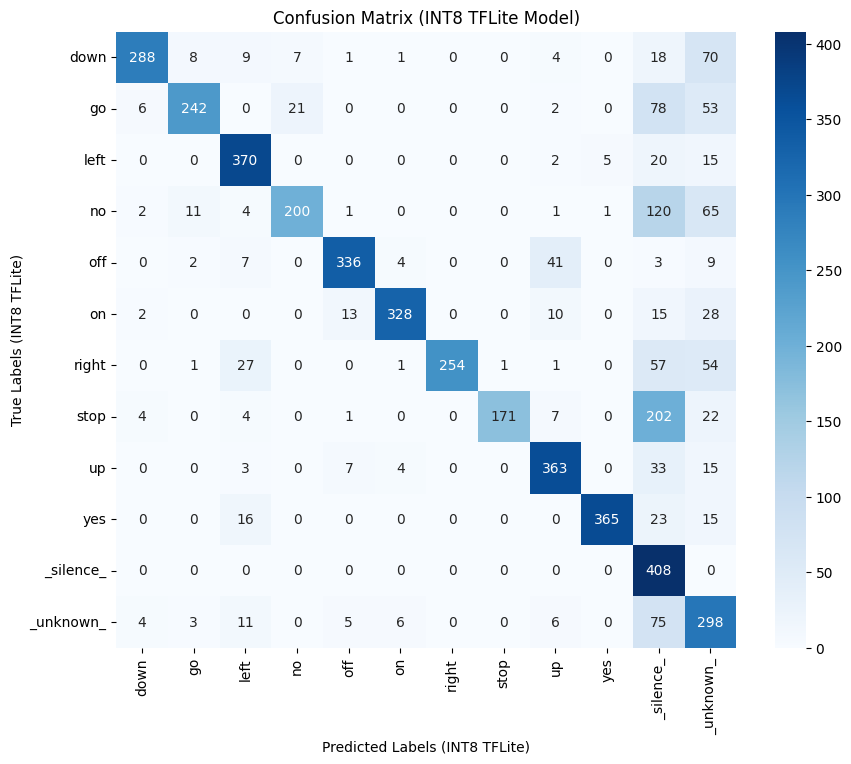

In [66]:
# --- Calculate Metrics ---
int8_test_accuracy = np.sum(y_true_int8 == y_pred_int8) / len(y_true_int8)
print(f"\nINT8 TFLite Model Test Accuracy: {int8_test_accuracy:.4f}")

# Classification Report
print("\nINT8 TFLite Model Classification Report:")
min_len = min(len(y_true_int8), len(y_pred_int8)) # Handle any minor length mismatches if any
print(classification_report(y_true_int8[:min_len], y_pred_int8[:min_len], target_names=config['all_model_labels'], zero_division=0))

# Confusion Matrix
conf_matrix_int8 = confusion_matrix(y_true_int8[:min_len], y_pred_int8[:min_len])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_int8, annot=True, fmt='d', cmap='Blues',
            xticklabels=config['all_model_labels'],
            yticklabels=config['all_model_labels'])
plt.xlabel('Predicted Labels (INT8 TFLite)')
plt.ylabel('True Labels (INT8 TFLite)')
plt.title('Confusion Matrix (INT8 TFLite Model)')
plt.show()

### C Array Conversion for Microcontroller Deployment

In order to produce the cc file and continue with the project, use command-line. 

Example:
```
xxd -i keyword_spotting_model_quant_88_int8.tflite > ../arduino_sketch_files/MyKeywordSpotterSketch/model_data.cc
```

In [67]:
# Final Model Artifacts and Size Reflection for MCU Deployment
print("--- Final Model Artifacts and Size Reflection for MCU Deployment ---")

models_dir = os.path.join('..', 'models')
tflite_models_dir = os.path.join('..', 'tflite_models')
mcu_code_dir = os.path.join('..', 'arduino_sketch_files', 'KeywordSpotterNano_SERIAL')

# --- 1. Best Keras Model ---
best_keras_model_filename = f'final_model_test_acc_{test_accuracy_best_val_acc:.2f}.keras'
keras_model_path = os.path.join(models_dir, best_keras_model_filename)

if os.path.exists(keras_model_path):
    keras_size_kb = os.path.getsize(keras_model_path) / 1024
    print(f"\n1. Original Keras Model ('{best_keras_model_filename}'):")
    print(f"   - Size: {keras_size_kb:.2f} KB")
    print(f"   - Test Accuracy (Keras): ~{test_accuracy_best_val_acc * 100}%")
else:
    print(f"\n1. Original Keras Model ('{best_keras_model_filename}'): File not found at {keras_model_path}")

# --- 2. Float32 TFLite Model ---
float32_tflite_filename = f'keyword_spotting_model_{test_accuracy_best_val_acc:.2f}_float32.tflite'
float32_tflite_path = os.path.join(tflite_models_dir, float32_tflite_filename)

if os.path.exists(float32_tflite_path):
    float32_tflite_size_kb = os.path.getsize(float32_tflite_path) / 1024
    print(f"\n2. Float32 TFLite Model ('{float32_tflite_filename}'):")
    print(f"   - Size: {float32_tflite_size_kb:.2f} KB")
else:
    print(f"\n2. Float32 TFLite Model ('{float32_tflite_filename}'): File not found at {float32_tflite_path}")
    float32_tflite_size_kb = 0

# --- 3. INT8 Quantized TFLite Model ---
int8_tflite_filename = f'keyword_spotting_model_{test_accuracy_best_val_acc:.2f}_int8.tflite'
int8_tflite_path = os.path.join(tflite_models_dir, int8_tflite_filename)

if os.path.exists(int8_tflite_path):
    int8_tflite_size_kb = os.path.getsize(int8_tflite_path) / 1024
    print(f"\n3. INT8 Quantized TFLite Model ('{int8_tflite_filename}'):")
    print(f"   - Size: {int8_tflite_size_kb:.2f} KB")
    if float32_tflite_size_kb > 0:
        reduction_from_float32 = ((float32_tflite_size_kb - int8_tflite_size_kb) / float32_tflite_size_kb) * 100
        print(f"   - Reduction vs Float32 TFLite: ~{reduction_from_float32:.1f}%")
    print(f"   - Test Accuracy (INT8 TFLite): {int8_test_accuracy:.4f}")
else:
    print(f"\n3. INT8 Quantized TFLite Model ('{int8_tflite_filename}'): File not found at {int8_tflite_path}")

# --- 4. C Array File ---
c_array_filename = 'model_data.cc'
c_array_path = os.path.join(mcu_code_dir, c_array_filename)

if os.path.exists(c_array_path):
    c_array_size_kb = os.path.getsize(c_array_path) / 1024
    print(f"\n4. C Array File ('{c_array_filename}') for embedding:")
    print(f"   - Size on Disk: {c_array_size_kb:.2f} KB")
    print(f"   - Note: The actual model data embedded in Flash will be closer to the INT8 TFLite model size ({int8_tflite_size_kb:.2f} KB).")
    print(f"     The .cc file is larger due to C syntax (hex formatting, variable names).")
else:
    print(f"\n4. C Array File ('{c_array_filename}'): File not found at {c_array_path}")

# --- MCU Memory Considerations (Arduino Nano 33 BLE Sense) ---
print("\n--- Target MCU Memory (Arduino Nano 33 BLE Sense - Approximate) ---")
flash_total_kb = 1024
flash_available_kb = 960 # Typical user available
sram_total_kb = 256

print(f" - Flash Memory (Program Storage): ~{flash_available_kb} KB available for sketch + model array + libraries.")
print(f" - SRAM (RAM): {sram_total_kb} KB available for variables, stack, and TFLM Tensor Arena.")

if 'int8_tflite_size_kb' in locals() and os.path.exists(int8_tflite_path):
    print(f"\nThe INT8 model size ({int8_tflite_size_kb:.2f} KB) is a key component for Flash usage.")
    print("The TFLM interpreter, audio processing code, and other libraries will also consume Flash.")
    print("The Tensor Arena size (SRAM) will depend on the model's specific layers and needs to be carefully determined for deployment.")
    if int8_tflite_size_kb < flash_available_kb / 4 : # Arbitrary check, e.g. if model < 1/4 of flash
        print("The model size appears suitable for Flash memory. Tensor Arena size will be the next critical factor for SRAM.")
    else:
        print("The model size is significant; careful optimization of the full firmware will be needed for Flash.")

print("\nThis concludes the Python-based model development and preparation for MCU deployment.")

--- Final Model Artifacts and Size Reflection for MCU Deployment ---

1. Original Keras Model ('final_model_test_acc_0.86.keras'):
   - Size: 354.38 KB
   - Test Accuracy (Keras): ~86.0%

2. Float32 TFLite Model ('keyword_spotting_model_0.86_float32.tflite'):
   - Size: 104.47 KB

3. INT8 Quantized TFLite Model ('keyword_spotting_model_0.86_int8.tflite'):
   - Size: 33.59 KB
   - Reduction vs Float32 TFLite: ~67.9%
   - Test Accuracy (INT8 TFLite): 0.7409

4. C Array File ('model_data.cc') for embedding:
   - Size on Disk: 213.02 KB
   - Note: The actual model data embedded in Flash will be closer to the INT8 TFLite model size (33.59 KB).
     The .cc file is larger due to C syntax (hex formatting, variable names).

--- Target MCU Memory (Arduino Nano 33 BLE Sense - Approximate) ---
 - Flash Memory (Program Storage): ~960 KB available for sketch + model array + libraries.
 - SRAM (RAM): 256 KB available for variables, stack, and TFLM Tensor Arena.

The INT8 model size (33.59 KB) is a k

In [ ]:

py_interpreter_int8 = tf.lite.Interpreter(model_path=f"../tflite_models/keyword_spotting_model_{test_accuracy_best_val_acc:.2f}_int8.tflite")
py_interpreter_int8.allocate_tensors()
py_input_details = py_interpreter_int8.get_input_details()[0]
py_output_details = py_interpreter_int8.get_output_details()[0]

# 1. Load the MFCC data from the file
filetest = "../utils/test_samples_for_arduino/sample_mfcc_off.npy"
mfcc_data = np.load(filetest)  # This loads the actual numpy array
print(f"Loaded MFCC data shape: {mfcc_data.shape}")

# 2. Add batch dimension (if needed - your data might already have it)
py_input_data = np.expand_dims(mfcc_data, axis=0) if len(mfcc_data.shape) == 3 else mfcc_data
print(f"Input data shape: {py_input_data.shape}")

# 3. Quantize the input data (float32 to int8)
input_scale, input_zero_point = py_input_details['quantization']
quantized_input = (py_input_data / input_scale) + input_zero_point
quantized_input = quantized_input.astype(np.int8)

# 4. Set the tensor and run inference
py_interpreter_int8.set_tensor(py_input_details['index'], quantized_input)
py_interpreter_int8.invoke()
py_output_data_int8 = py_interpreter_int8.get_tensor(py_output_details['index'])[0]

py_predicted_class_idx = np.argmax(py_output_data_int8)
print(f"Predicted class index: {py_predicted_class_idx}")
# Convert the predicted class index back to label

#Int to label mapping for model: {0: 'down', 1: 'go', 2: 'left', 3: 'no', 4: 'off', 5: 'on', 6: 'right', 7: 'stop', 8: 'up', 9: 'yes', 10: '_silence_', 11: '_unknown_'}


Loaded MFCC data shape: (13, 100, 1)
Input data shape: (1, 13, 100, 1)
Predicted class index: 4
